In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler


D:\Anaconda\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
tickersfile = r'C:\Users\mikel\Desktop\FYP\棒棒棒\tickers.csv'
tickers  = pd.read_csv(tickersfile)

In [3]:
ticker_series = tickers['Holding Ticker']
ticker_series = ticker_series.str.strip()
# Convert the pandas Series to a list of tickers
ticker_list = ticker_series.tolist()
# Define the date range for downloading the stock data
start_date = '2022-12-16'
end_date = '2024-04-25'

# Download the stock data for the list of tickers
data = yf.download(ticker_list, start=start_date, end=end_date)
data = data['Adj Close'].dropna().pct_change()[1:]
# Save the data 
data.to_csv('stock_data.csv')

[*********************100%%**********************]  101 of 101 completed


In [4]:
ticker = "QQQ"
QQQ = yf.download(ticker, start=start_date, end=end_date)

# Calculate daily percentage return
QQQ_returns = QQQ['Adj Close'].pct_change()[1:]

[*********************100%%**********************]  1 of 1 completed


In [5]:
import os

# Calculate the number of rows needed for an 80% split
split_index = int(len(data) * 0.8)

# Split the data into calibration and validation sets
calibration = data.iloc[:split_index]
validation = data.iloc[split_index:]

QQQ_cali = QQQ_returns.iloc[:split_index]
QQQ_vali = QQQ_returns.iloc[split_index:]

In [81]:
validation

Ticker,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,TTD,TTWO,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-18,0.032571,0.015262,-0.004026,0.024484,0.002931,0.011364,-0.019190,0.045446,0.015608,0.001348,...,0.008527,-0.003242,0.027644,0.003718,-0.001798,-0.000902,0.011811,0.015498,-0.007322,0.011450
2024-01-19,0.015533,0.021089,0.030066,0.025267,0.009149,0.030931,-0.006394,0.047399,0.071064,0.010903,...,0.027671,0.020268,0.040381,0.010819,0.004711,-0.006772,0.006809,0.015087,-0.002850,0.014830
2024-01-22,0.012163,0.014865,-0.013016,0.013041,0.004869,0.008647,-0.005663,0.002144,-0.034724,0.007635,...,0.037996,0.008154,0.006795,0.013910,0.011701,0.025455,0.011594,-0.000379,-0.009247,0.041333
2024-01-23,0.006653,0.002042,-0.010620,0.020577,0.004010,0.007935,0.011002,-0.007427,0.001427,-0.000806,...,0.011385,0.004379,-0.002803,0.001561,-0.000932,0.000887,0.006686,0.004968,0.004412,0.007224
2024-01-24,-0.003484,-0.007800,0.015573,-0.015246,-0.007988,-0.000475,-0.014339,0.042442,0.058603,-0.014230,...,-0.007552,0.004541,-0.024492,0.003322,-0.027610,-0.009300,-0.012334,0.014348,-0.016388,-0.004988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-18,-0.005714,0.010924,-0.002677,-0.009766,-0.003746,-0.019961,0.016248,-0.027865,0.006882,-0.004999,...,0.008486,-0.017603,-0.012251,0.004859,0.000967,-0.002269,0.009721,-0.005369,0.010716,0.000058
2024-04-19,-0.012213,-0.031793,-0.017245,-0.022497,0.005455,0.027869,0.019864,-0.023415,-0.054424,0.023520,...,-0.043435,-0.000284,-0.024378,-0.003627,0.002033,0.036953,0.010830,-0.013378,0.017857,-0.021738
2024-04-22,0.005091,0.010322,0.004021,0.016089,0.012330,0.002910,0.008314,-0.001634,0.013639,0.011081,...,0.006986,-0.004552,0.023484,0.002921,0.014305,-0.001097,0.008333,0.005194,0.004386,0.010401


In [7]:
QQQ_returns

Date
2022-12-19   -0.014054
2022-12-20   -0.000778
2022-12-21    0.014506
2022-12-22   -0.024465
2022-12-23    0.002249
                ...   
2024-04-18   -0.005706
2024-04-19   -0.020689
2024-04-22    0.010057
2024-04-23    0.014923
2024-04-24    0.003388
Name: Adj Close, Length: 338, dtype: float64

In [8]:
volatility = data.std()

# Rank the stocks by volatility
sorted_volatility = volatility.sort_values(ascending=False)

# Select the top 20 most volatile stocks
top_20_volatile_stocks = sorted_volatility.head(20)

# Calculate the total volatility of the top 20 most volatile stocks
total_volatility = top_20_volatile_stocks.sum()

# Print the total volatility
print("Total volatility of the top 20 most volatile stocks:", total_volatility)

Total volatility of the top 20 most volatile stocks: 0.6213799461099978


Epoch 1/300


D:\Anaconda\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step - loss: 0.0012
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0012
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0012
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0012
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0011
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0011
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0011
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0011
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0010
Epoch 10/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0010
Epoch 11/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 9.8792e-04
Epoch 12/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.6697e-04
Epoch 13/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 9.4668e-04
Epoch 14/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 9.2691e-04
Epoch 15/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 9.0758e-04
Epoch 16/3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.0284e-04
Epoch 81/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.9990e-04
Epoch 82/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.9709e-04
Epoch 83/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.9445e-04
Epoch 84/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.9195e-04
Epoch 85/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.8961e-04
Epoch 86/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.8742e-04
Epoch 87/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.8537e-04
Epoch 88/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.8347e-04
Epoch 89/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.8171e-04
Epoch 90/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.8007e-04
Epoch 91/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.7855e-04
Epoch 92/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.7713e-04
Epoch 93/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.7581e-04
Epoch 94/300
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.6042e-04
Epoch 159/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.6041e-04
Epoch 160/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.6040e-04
Epoch 161/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.6039e-04
Epoch 162/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.6038e-04
Epoch 163/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.6038e-04
Epoch 164/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.6037e-04
Epoch 165/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.6036e-04
Epoch 166/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.6036e-04
Epoch 167/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.6035e-04
Epoch 168/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.6035e-04
Epoch 169/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.6035e-04
Epoch 170/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.6034e-04
Epoch 171/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.6034e-04
Epoch 172/300
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.6029e-04
Epoch 237/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.6029e-04
Epoch 238/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.6029e-04
Epoch 239/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.6029e-04
Epoch 240/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.6029e-04
Epoch 241/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.6029e-04
Epoch 242/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.6029e-04
Epoch 243/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.6029e-04
Epoch 244/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.6029e-04
Epoch 245/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.6029e-04
Epoch 246/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.6029e-04
Epoch 247/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.6029e-04
Epoch 248/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.6029e-04
Epoch 249/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.6029e-04
Epoch 250/300
1/1 ━━

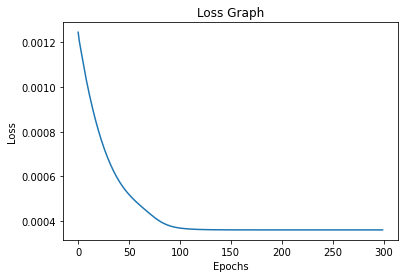

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [22]:
encoding_dim = 5 # 5 neurons
num_stock = len(calibration.columns) # Use 83 stocks as features

autoencoder = Sequential()
autoencoder.add(Dense(encoding_dim, activation='relu', input_shape=(num_stock,),kernel_regularizer=l2(0.00005)))
autoencoder.add(Dense(num_stock, activation='linear',kernel_regularizer=l2(0.00003)))

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.003), loss='mean_squared_error')

# Train the model
history = autoencoder.fit(calibration, calibration, epochs=300, batch_size=500)
losses = history.history['loss']
plt.plot(losses)
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
# test/reconstruct market information matrix
reconstruct = autoencoder.predict(calibration)

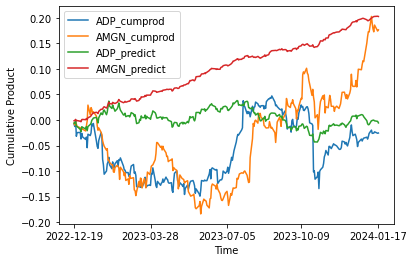

In [26]:
# Create a figure and axis
fig, ax = plt.subplots()

ADP_cumprod = (1 + calibration.iloc[:]['ADP']).cumprod().to_frame(name='values')
AMGN_cumprod = (1 + calibration.iloc[:]['AMGN']).cumprod().to_frame(name='values')
ADP_index = calibration.columns.get_loc('ADP')
AMGN_index = calibration.columns.get_loc('AMGN')

ax.plot(ADP_cumprod.index, ADP_cumprod['values']-1, label='ADP_cumprod')
ax.plot(AMGN_cumprod.index, AMGN_cumprod['values']-1, label='AMGN_cumprod')

indices = np.linspace(0, len(ADP_cumprod.index) - 1, 5, dtype=int)
dates_show = ADP_cumprod.index[indices]

# Plot the IBB_predict[s] lines for each 's'
ADP_predict_cumprod = (1 + reconstruct[:,ADP_index]).cumprod()
AMGN_predict_cumprod = (1 + reconstruct[:,AMGN_index]).cumprod()

# Convert ndarray to pandas Series with the same index as ibb_cumprod
ADP_predict_series = pd.Series(ADP_predict_cumprod, index=ADP_cumprod.index)
AMGN_predict_series = pd.Series(AMGN_predict_cumprod, index=AMGN_cumprod.index)

ax.plot(ADP_predict_series.index, ADP_predict_series - 1, label=f'ADP_predict')
ax.plot(AMGN_predict_series.index, AMGN_predict_series - 1, label=f'AMGN_predict')

# Set x-axis ticks and labels
ax.set_xticks(dates_show)

# Add labels and legend
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Product')
ax.legend()

# Display the plot
plt.show()

In [27]:
communal_information = []

for i in range(0,num_stock):
    diff = np.linalg.norm((calibration.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
ranking = np.array(communal_information).argsort()

sorted_indices = np.argsort(ranking)
stock_codes = calibration.columns[:]
sorted_stock_codes = stock_codes[sorted_indices]
rankings_and_codes = []
# Print the ranking and corresponding stock code
for rank, stock_code in enumerate(sorted_stock_codes, start=1):
    rankings_and_codes.append((rank, stock_code))
rankings_dict = {code: rank for rank, code in rankings_and_codes}

In [28]:
rankings_dict

{'ADP': 1,
 'REGN': 2,
 'ILMN': 3,
 'AZN': 4,
 'BKR': 5,
 'IDXX': 6,
 'DXCM': 7,
 'INTU': 8,
 'SBUX': 9,
 'DASH': 10,
 'MDLZ': 11,
 'MRVL': 12,
 'EXC': 13,
 'KLAC': 14,
 'GOOG': 15,
 'DLTR': 16,
 'GFS': 17,
 'MNST': 18,
 'AMAT': 19,
 'CTAS': 20,
 'GEHC': 21,
 'MDB': 22,
 'NXPI': 23,
 'FTNT': 24,
 'ADI': 25,
 'ADSK': 26,
 'PAYX': 27,
 'AVGO': 28,
 'HON': 29,
 'CCEP': 30,
 'AMD': 31,
 'EA': 32,
 'ROST': 33,
 'WBD': 34,
 'NFLX': 35,
 'SNPS': 36,
 'CDW': 37,
 'FAST': 38,
 'NVDA': 39,
 'BIIB': 40,
 'SIRI': 41,
 'MSFT': 42,
 'MRNA': 43,
 'CSCO': 44,
 'MAR': 45,
 'LULU': 46,
 'ADBE': 47,
 'LIN': 48,
 'TTWO': 49,
 'PANW': 50,
 'CTSH': 51,
 'META': 52,
 'ANSS': 53,
 'AMZN': 54,
 'KDP': 55,
 'ASML': 56,
 'MELI': 57,
 'ODFL': 58,
 'DDOG': 59,
 'GOOGL': 60,
 'WBA': 61,
 'AMGN': 62,
 'QCOM': 63,
 'PDD': 64,
 'CHTR': 65,
 'VRTX': 66,
 'TMUS': 67,
 'CRWD': 68,
 'ON': 69,
 'PEP': 70,
 'TEAM': 71,
 'GILD': 72,
 'MU': 73,
 'ROP': 74,
 'CPRT': 75,
 'PYPL': 76,
 'CMCSA': 77,
 'FANG': 78,
 'XEL': 79,
 'ABN

In [29]:
calibration

Ticker,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,TTD,TTWO,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-19,-0.015910,-0.040639,-0.028889,-0.010071,-0.008055,-0.020062,-0.006027,-0.007066,-0.012536,-0.006395,...,-0.043770,-0.021536,-0.011442,-0.010285,-0.043340,0.006914,-0.066599,-0.029563,-0.007437,-0.016986
2022-12-20,-0.000529,0.019667,0.028775,-0.004905,-0.004693,-0.003288,-0.003511,-0.004712,0.007122,-0.003575,...,0.055744,-0.004869,-0.009069,-0.005946,0.005624,0.005341,-0.023784,0.012056,0.001297,0.011312
2022-12-21,0.023809,-0.006277,0.009343,0.018743,0.012833,0.022935,0.017829,0.023188,0.040430,0.005703,...,-0.000429,0.018041,0.015895,0.022824,-0.009140,-0.023527,0.001107,-0.011680,0.013240,-0.006782
2022-12-22,-0.023772,-0.025267,-0.014236,-0.021862,-0.031898,-0.021485,-0.009125,-0.078376,-0.056442,-0.003756,...,-0.035860,-0.006107,-0.023884,-0.009312,0.011599,-0.004145,0.021018,-0.026282,-0.005397,-0.030239
2022-12-23,-0.002798,0.004477,0.005735,0.000549,0.007443,0.000319,0.012914,-0.003893,0.010335,-0.005052,...,-0.000445,0.005641,-0.001943,0.006476,-0.014392,0.004943,-0.006500,-0.005857,0.012852,-0.005304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-10,0.005671,0.001648,0.008240,-0.007325,0.000298,0.012121,-0.018899,-0.008078,-0.004824,-0.008755,...,0.000438,-0.000063,-0.008184,-0.003238,0.006532,-0.026814,-0.005440,0.003589,-0.008693,-0.003801
2024-01-11,-0.003222,-0.002218,0.010930,0.003132,0.000213,0.007663,-0.025927,0.014285,-0.003501,-0.004826,...,-0.005841,0.014635,-0.009865,0.001069,0.014914,-0.026337,-0.039198,0.007803,-0.027423,0.013842
2024-01-12,0.001778,-0.016565,-0.001590,-0.003175,0.002592,0.007438,0.013557,-0.004607,-0.009864,0.011250,...,-0.016451,0.000867,-0.004408,0.010930,0.007720,-0.031627,0.010436,0.015306,0.005082,0.009846


In [30]:
QQQ_cali

Date
2022-12-19   -0.014054
2022-12-20   -0.000778
2022-12-21    0.014506
2022-12-22   -0.024465
2022-12-23    0.002249
                ...   
2024-01-10    0.006778
2024-01-11    0.002081
2024-01-12    0.000513
2024-01-16   -0.000098
2024-01-17   -0.005641
Name: Adj Close, Length: 270, dtype: float64

Epoch 1/550


D:\Anaconda\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 2.8578 - learning_rate: 0.2000
Epoch 2/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3287 - learning_rate: 0.2000
Epoch 3/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1640 - learning_rate: 0.2000
Epoch 4/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1042 - learning_rate: 0.2000
Epoch 5/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0745 - learning_rate: 0.2000
Epoch 6/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0578 - learning_rate: 0.2000
Epoch 7/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0470 - learning_rate: 0.2000
Epoch 8/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0394 - learning_rate: 0.2000
Epoch 9/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0338 - learning_rate: 0.2000
Epoch 10/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0296 - learning_rate: 0.2000
Epoch 11/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0262 - learning_rate: 0.2000
Epoch 12/550
1/1 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0013 - learning_rate: 0.2000
Epoch 68/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0012 - learning_rate: 0.2000
Epoch 69/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0012 - learning_rate: 0.2000
Epoch 70/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0012 - learning_rate: 0.2000
Epoch 71/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0012 - learning_rate: 0.2000
Epoch 72/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0011 - learning_rate: 0.2000
Epoch 73/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0011 - learning_rate: 0.2000
Epoch 74/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0011 - learning_rate: 0.2000
Epoch 75/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0011 - learning_rate: 0.2000
Epoch 76/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0010 - learning_rate: 0.2000
Epoch 77/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0010 - learning_rate: 0.2000
Epoch 78/550
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.8884e-04 - learning_rate: 0.1400
Epoch 132/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.8763e-04 - learning_rate: 0.1400
Epoch 133/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.8646e-04 - learning_rate: 0.1400
Epoch 134/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.8533e-04 - learning_rate: 0.1400
Epoch 135/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.8425e-04 - learning_rate: 0.1400
Epoch 136/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.8320e-04 - learning_rate: 0.1400
Epoch 137/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.8219e-04 - learning_rate: 0.1400
Epoch 138/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 6.8122e-04 - learning_rate: 0.1400
Epoch 139/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.8028e-04 - learning_rate: 0.1400
Epoch 140/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.7937e-04 - learning_rate: 0.1400
Epoch 141/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.78

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 6.5763e-04 - learning_rate: 0.1400
Epoch 195/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.5749e-04 - learning_rate: 0.1400
Epoch 196/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5735e-04 - learning_rate: 0.1400
Epoch 197/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5721e-04 - learning_rate: 0.1400
Epoch 198/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5707e-04 - learning_rate: 0.1400
Epoch 199/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5694e-04 - learning_rate: 0.1400
Epoch 200/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5681e-04 - learning_rate: 0.1400
Epoch 201/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5669e-04 - learning_rate: 0.0700
Epoch 202/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.5663e-04 - learning_rate: 0.0700
Epoch 203/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5657e-04 - learning_rate: 0.0700
Epoch 204/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.56

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.5421e-04 - learning_rate: 0.0700
Epoch 258/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5418e-04 - learning_rate: 0.0700
Epoch 259/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.5414e-04 - learning_rate: 0.0700
Epoch 260/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5411e-04 - learning_rate: 0.0700
Epoch 261/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.5408e-04 - learning_rate: 0.0700
Epoch 262/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5405e-04 - learning_rate: 0.0700
Epoch 263/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5402e-04 - learning_rate: 0.0700
Epoch 264/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5399e-04 - learning_rate: 0.0700
Epoch 265/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5396e-04 - learning_rate: 0.0700
Epoch 266/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5393e-04 - learning_rate: 0.0700
Epoch 267/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.53

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5267e-04 - learning_rate: 0.0500
Epoch 321/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 6.5266e-04 - learning_rate: 0.0500
Epoch 322/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.5264e-04 - learning_rate: 0.0500
Epoch 323/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5263e-04 - learning_rate: 0.0500
Epoch 324/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5261e-04 - learning_rate: 0.0500
Epoch 325/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5260e-04 - learning_rate: 0.0500
Epoch 326/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.5258e-04 - learning_rate: 0.0500
Epoch 327/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.5256e-04 - learning_rate: 0.0500
Epoch 328/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.5255e-04 - learning_rate: 0.0500
Epoch 329/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5253e-04 - learning_rate: 0.0500
Epoch 330/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.52

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5174e-04 - learning_rate: 0.0500
Epoch 384/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5173e-04 - learning_rate: 0.0500
Epoch 385/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.5172e-04 - learning_rate: 0.0500
Epoch 386/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5170e-04 - learning_rate: 0.0500
Epoch 387/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5169e-04 - learning_rate: 0.0500
Epoch 388/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5167e-04 - learning_rate: 0.0500
Epoch 389/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5166e-04 - learning_rate: 0.0500
Epoch 390/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.5165e-04 - learning_rate: 0.0500
Epoch 391/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5163e-04 - learning_rate: 0.0500
Epoch 392/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5162e-04 - learning_rate: 0.0500
Epoch 393/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.51

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5090e-04 - learning_rate: 0.0500
Epoch 447/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5089e-04 - learning_rate: 0.0500
Epoch 448/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5088e-04 - learning_rate: 0.0500
Epoch 449/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.5086e-04 - learning_rate: 0.0500
Epoch 450/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.5085e-04 - learning_rate: 0.0500
Epoch 451/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5084e-04 - learning_rate: 0.0500
Epoch 452/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.5083e-04 - learning_rate: 0.0500
Epoch 453/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.5081e-04 - learning_rate: 0.0500
Epoch 454/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5080e-04 - learning_rate: 0.0500
Epoch 455/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5079e-04 - learning_rate: 0.0500
Epoch 456/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.50

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5010e-04 - learning_rate: 0.0500
Epoch 510/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5009e-04 - learning_rate: 0.0500
Epoch 511/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5008e-04 - learning_rate: 0.0500
Epoch 512/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5007e-04 - learning_rate: 0.0500
Epoch 513/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5005e-04 - learning_rate: 0.0500
Epoch 514/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.5004e-04 - learning_rate: 0.0500
Epoch 515/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5003e-04 - learning_rate: 0.0500
Epoch 516/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5002e-04 - learning_rate: 0.0500
Epoch 517/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 6.5000e-04 - learning_rate: 0.0500
Epoch 518/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.4999e-04 - learning_rate: 0.0500
Epoch 519/550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.49

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


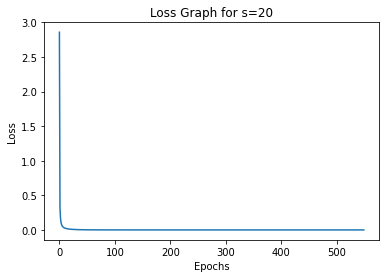

Epoch 1/450


D:\Anaconda\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 1.4106 - learning_rate: 0.2000
Epoch 2/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6740 - learning_rate: 0.2000
Epoch 3/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0813 - learning_rate: 0.2000
Epoch 4/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0591 - learning_rate: 0.2000
Epoch 5/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0454 - learning_rate: 0.2000
Epoch 6/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0361 - learning_rate: 0.2000
Epoch 7/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0294 - learning_rate: 0.2000
Epoch 8/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0244 - learning_rate: 0.2000
Epoch 9/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0204 - learning_rate: 0.2000
Epoch 10/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0174 - learning_rate: 0.2000
Epoch 11/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0149 - learning_rate: 0.2000
Epoch 12/450
1/1 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.6830e-04 - learning_rate: 0.2000
Epoch 67/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.6663e-04 - learning_rate: 0.2000
Epoch 68/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.6515e-04 - learning_rate: 0.2000
Epoch 69/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.6383e-04 - learning_rate: 0.2000
Epoch 70/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.6265e-04 - learning_rate: 0.2000
Epoch 71/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.6160e-04 - learning_rate: 0.2000
Epoch 72/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.6066e-04 - learning_rate: 0.2000
Epoch 73/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.5981e-04 - learning_rate: 0.2000
Epoch 74/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.5906e-04 - learning_rate: 0.2000
Epoch 75/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.5838e-04 - learning_rate: 0.2000
Epoch 76/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.5778e-04 - l

Epoch 130/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.5052e-04 - learning_rate: 0.1400
Epoch 131/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.5048e-04 - learning_rate: 0.1400
Epoch 132/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.5043e-04 - learning_rate: 0.1400
Epoch 133/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 8.5038e-04 - learning_rate: 0.1400
Epoch 134/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.5033e-04 - learning_rate: 0.1400
Epoch 135/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.5028e-04 - learning_rate: 0.1400
Epoch 136/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.5023e-04 - learning_rate: 0.1400
Epoch 137/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.5019e-04 - learning_rate: 0.1400
Epoch 138/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.5014e-04 - learning_rate: 0.1400
Epoch 139/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.5009e-04 - learning_rate: 0.1400
Epoch 140/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.4755e-04 - learning_rate: 0.1400
Epoch 194/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.4750e-04 - learning_rate: 0.1400
Epoch 195/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.4746e-04 - learning_rate: 0.1400
Epoch 196/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4741e-04 - learning_rate: 0.1400
Epoch 197/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 8.4736e-04 - learning_rate: 0.1400
Epoch 198/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.4732e-04 - learning_rate: 0.1400
Epoch 199/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.4727e-04 - learning_rate: 0.1400
Epoch 200/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.4722e-04 - learning_rate: 0.1400
Epoch 201/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4717e-04 - learning_rate: 0.0700
Epoch 202/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4715e-04 - learning_rate: 0.0700
Epoch 203/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.47

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4589e-04 - learning_rate: 0.0700
Epoch 257/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.4586e-04 - learning_rate: 0.0700
Epoch 258/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4584e-04 - learning_rate: 0.0700
Epoch 259/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4582e-04 - learning_rate: 0.0700
Epoch 260/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4579e-04 - learning_rate: 0.0700
Epoch 261/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4577e-04 - learning_rate: 0.0700
Epoch 262/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4575e-04 - learning_rate: 0.0700
Epoch 263/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4572e-04 - learning_rate: 0.0700
Epoch 264/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4570e-04 - learning_rate: 0.0700
Epoch 265/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4568e-04 - learning_rate: 0.0700
Epoch 266/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.45

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4454e-04 - learning_rate: 0.0500
Epoch 320/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4452e-04 - learning_rate: 0.0500
Epoch 321/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4450e-04 - learning_rate: 0.0500
Epoch 322/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4449e-04 - learning_rate: 0.0500
Epoch 323/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4447e-04 - learning_rate: 0.0500
Epoch 324/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 8.4445e-04 - learning_rate: 0.0500
Epoch 325/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 8.4444e-04 - learning_rate: 0.0500
Epoch 326/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.4442e-04 - learning_rate: 0.0500
Epoch 327/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.4440e-04 - learning_rate: 0.0500
Epoch 328/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4439e-04 - learning_rate: 0.0500
Epoch 329/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.44

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.4349e-04 - learning_rate: 0.0500
Epoch 383/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4347e-04 - learning_rate: 0.0500
Epoch 384/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4345e-04 - learning_rate: 0.0500
Epoch 385/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.4344e-04 - learning_rate: 0.0500
Epoch 386/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.4342e-04 - learning_rate: 0.0500
Epoch 387/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4340e-04 - learning_rate: 0.0500
Epoch 388/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.4339e-04 - learning_rate: 0.0500
Epoch 389/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.4337e-04 - learning_rate: 0.0500
Epoch 390/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4335e-04 - learning_rate: 0.0500
Epoch 391/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 8.4334e-04 - learning_rate: 0.0500
Epoch 392/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.43

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.4244e-04 - learning_rate: 0.0500
Epoch 446/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.4242e-04 - learning_rate: 0.0500
Epoch 447/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.4240e-04 - learning_rate: 0.0500
Epoch 448/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4239e-04 - learning_rate: 0.0500
Epoch 449/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4237e-04 - learning_rate: 0.0500
Epoch 450/450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4235e-04 - learning_rate: 0.0500


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


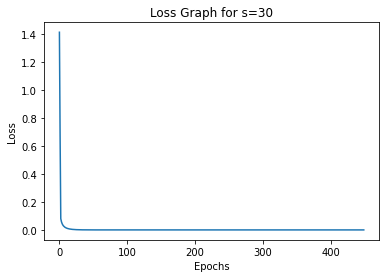

Epoch 1/350


D:\Anaconda\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 1.8331 - learning_rate: 0.2000
Epoch 2/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1825 - learning_rate: 0.2000
Epoch 3/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0648 - learning_rate: 0.2000
Epoch 4/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0460 - learning_rate: 0.2000
Epoch 5/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0368 - learning_rate: 0.2000
Epoch 6/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0303 - learning_rate: 0.2000
Epoch 7/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0254 - learning_rate: 0.2000
Epoch 8/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0214 - learning_rate: 0.2000
Epoch 9/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0183 - learning_rate: 0.2000
Epoch 10/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0157 - learning_rate: 0.2000
Epoch 11/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0136 - learning_rate: 0.2000
Epoch 12/350
1/1 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.1238e-04 - learning_rate: 0.2000
Epoch 67/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 8.1097e-04 - learning_rate: 0.2000
Epoch 68/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.0972e-04 - learning_rate: 0.2000
Epoch 69/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.0860e-04 - learning_rate: 0.2000
Epoch 70/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.0761e-04 - learning_rate: 0.2000
Epoch 71/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.0673e-04 - learning_rate: 0.2000
Epoch 72/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.0594e-04 - learning_rate: 0.2000
Epoch 73/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.0523e-04 - learning_rate: 0.2000
Epoch 74/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.0460e-04 - learning_rate: 0.2000
Epoch 75/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.0404e-04 - learning_rate: 0.2000
Epoch 76/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.0353e-04 - l

Epoch 130/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9725e-04 - learning_rate: 0.1400
Epoch 131/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9721e-04 - learning_rate: 0.1400
Epoch 132/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9716e-04 - learning_rate: 0.1400
Epoch 133/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 7.9712e-04 - learning_rate: 0.1400
Epoch 134/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.9707e-04 - learning_rate: 0.1400
Epoch 135/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.9702e-04 - learning_rate: 0.1400
Epoch 136/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.9698e-04 - learning_rate: 0.1400
Epoch 137/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9693e-04 - learning_rate: 0.1400
Epoch 138/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.9689e-04 - learning_rate: 0.1400
Epoch 139/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.9684e-04 - learning_rate: 0.1400
Epoch 140/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9440e-04 - learning_rate: 0.1400
Epoch 194/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.9435e-04 - learning_rate: 0.1400
Epoch 195/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.9431e-04 - learning_rate: 0.1400
Epoch 196/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9426e-04 - learning_rate: 0.1400
Epoch 197/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9422e-04 - learning_rate: 0.1400
Epoch 198/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.9417e-04 - learning_rate: 0.1400
Epoch 199/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.9413e-04 - learning_rate: 0.1400
Epoch 200/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9408e-04 - learning_rate: 0.1400
Epoch 201/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9404e-04 - learning_rate: 0.0700
Epoch 202/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.9401e-04 - learning_rate: 0.0700
Epoch 203/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.93

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.9280e-04 - learning_rate: 0.0700
Epoch 257/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 7.9278e-04 - learning_rate: 0.0700
Epoch 258/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.9276e-04 - learning_rate: 0.0700
Epoch 259/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9273e-04 - learning_rate: 0.0700
Epoch 260/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.9271e-04 - learning_rate: 0.0700
Epoch 261/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.9269e-04 - learning_rate: 0.0700
Epoch 262/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 7.9267e-04 - learning_rate: 0.0700
Epoch 263/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9264e-04 - learning_rate: 0.0700
Epoch 264/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.9262e-04 - learning_rate: 0.0700
Epoch 265/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 7.9260e-04 - learning_rate: 0.0700
Epoch 266/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.92

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.9151e-04 - learning_rate: 0.0500
Epoch 320/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.9149e-04 - learning_rate: 0.0500
Epoch 321/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9147e-04 - learning_rate: 0.0500
Epoch 322/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.9146e-04 - learning_rate: 0.0500
Epoch 323/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.9144e-04 - learning_rate: 0.0500
Epoch 324/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.9143e-04 - learning_rate: 0.0500
Epoch 325/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9141e-04 - learning_rate: 0.0500
Epoch 326/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9139e-04 - learning_rate: 0.0500
Epoch 327/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.9138e-04 - learning_rate: 0.0500
Epoch 328/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.9136e-04 - learning_rate: 0.0500
Epoch 329/350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.91

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


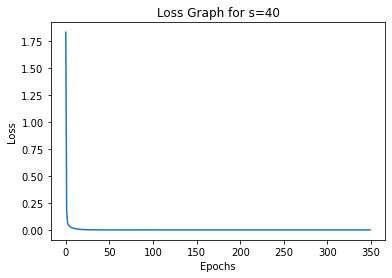

In [77]:
QQQ_predict = {}
total_2_norm_diff = {}
dl_scaler = defaultdict(StandardScaler)
ep = {20: 550, 30: 450, 40: 350}
losses = {}
def scheduler(epoch, lr):
    if epoch < 100:
        return 0.2
    elif 100 <= epoch < 200:
        return 0.14
    elif 200 <= epoch < 300:
        return 0.07
    else:
        return 0.05
    
# Create a LearningRateScheduler callback instance
lr_callback = LearningRateScheduler(scheduler)

for non_communal in [10, 20, 30]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal

    # Create and compile the model
    deep_learner = Sequential()
    deep_learner.add(Dense(encoding_dim, activation='relu', input_shape=(s,), kernel_regularizer=l2(0.0001)))
    deep_learner.add(Dense(1, activation='linear', kernel_regularizer=l2(0.0001)))
    deep_learner.compile(optimizer=SGD(learning_rate=0.15), loss='mean_squared_error')

    bottom_codes = sorted(rankings_dict, key=rankings_dict.get)[-non_communal:]
    top_codes = sorted(rankings_dict, key=rankings_dict.get)[:10]
    stockcodes = np.concatenate((top_codes, bottom_codes))
    
    x = calibration.loc[:,stockcodes]
    y = QQQ_cali
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    history = deep_learner.fit(x, y, epochs=ep[s], batch_size=300, callbacks=[lr_callback])
    deep_learner.save('model/retrack_s' + str(s) + '.h5') # fo[r validation phase use
    QQQ_predict[s] = deep_learner.predict(x).flatten()
    
    total_2_norm_diff[s] = np.linalg.norm((QQQ_predict[s] - QQQ_cali.squeeze()).dropna())   
    losses[s] = history.history['loss']
    
    plt.plot(losses[s])
    plt.title('Loss Graph for s=' + str(s))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

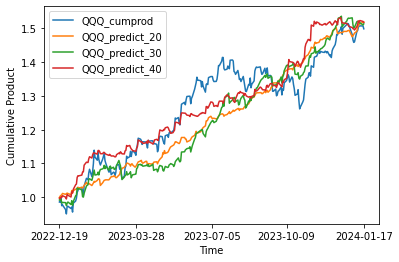

S20 2-norm difference:  0.1762336952686523
S30 2-norm difference:  0.13864709976565545
S40 2-norm difference:  0.15918832100415417


In [78]:
# Plot the QQQ_cumprod line
fig, ax = plt.subplots()
QQQ_cumprod = (1 + QQQ_cali).cumprod()
plt.plot(QQQ_cumprod, label='QQQ_cumprod')

# Plot the QQQ_predict[s] lines for each 's'
for s in [20, 30, 40]:
    QQQ_predict_cumprod = (1 + QQQ_predict[s]).cumprod()
    QQQ_predict_series = pd.Series(QQQ_predict_cumprod, index=QQQ_cumprod.index)
    plt.plot(QQQ_predict_series, label=f'QQQ_predict_{s}')

indices = np.linspace(0, len(QQQ_cumprod.index) - 1, 5, dtype=int)
dates_show = QQQ_cumprod.index[indices]
# Set x-axis ticks and labels
ax.set_xticks(dates_show)

# Add labels and legend
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Product')
ax.legend()

# Display the plot
plt.show()

for s in [20, 30, 40]:
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff[s])    

In [79]:
QQQ_predict_Val = {}
total_2_norm_diff_Val = {}
for non_communal in [10, 20, 30]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    
    # construct and compile deep learning routine
    deep_learner = load_model('model/retrack_s' + str(s) + '.h5')
    
    bottom_codes = sorted(rankings_dict, key=rankings_dict.get)[:non_communal]
    top_codes = sorted(rankings_dict, key=rankings_dict.get)[:10]
    stockcodes = np.concatenate((top_codes, bottom_codes))
    
    x = validation.loc[:,stockcodes]
    y = QQQ_vali
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    QQQ_predict_Val[s] = deep_learner.predict(x).flatten()
    arr_series = pd.Series(QQQ_predict_Val[s])
    index_mapping = dict(zip(arr_series.index, y.index))

    QQQ_predict_Val[s] = arr_series.rename(index=index_mapping)
    
    total_2_norm_diff_Val[s] = np.linalg.norm((QQQ_predict_Val[s] - QQQ_vali.squeeze()).dropna())    

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


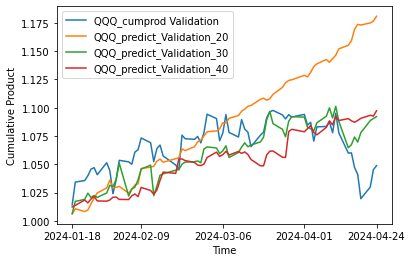

S20 2-norm difference:  0.08473866261068194
S30 2-norm difference:  0.07599415002154884
S40 2-norm difference:  0.0847257454429471


In [80]:

fig, ax = plt.subplots()

# Plot the QQQ_cumprod line
QQQ_cumprod_Val = (1 + QQQ_vali).cumprod()
plt.plot(QQQ_cumprod_Val, label='QQQ_cumprod Validation')

# Plot the QQQ_predict[s] lines for each 's'
for s in [20, 30, 40]:
    QQQ_predict_Val_cumprod = (1 + QQQ_predict_Val[s]).cumprod()
    QQQ_predict_Val_series = pd.Series(QQQ_predict_Val_cumprod, index=QQQ_predict_Val_cumprod.index)
    plt.plot(QQQ_predict_Val_series, label=f'QQQ_predict_Validation_{s}')

indices = np.linspace(0, len(QQQ_predict_Val_cumprod.index) - 1, 5, dtype=int)
dates_show = QQQ_predict_Val_cumprod.index[indices]
# Set x-axis ticks and labels
ax.set_xticks(dates_show)

# Add labels and legend
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Product')
ax.legend()

# Display the plot
plt.show()

for s in [20, 30, 40]:
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff_Val[s])    

In [19]:
QQQ_predict_Ver = {}
error = []
for non_communal in range(5, 89, 5):
    
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index


    deep_learner = Sequential()
    deep_learner.add(Dense(encoding_dim, activation='relu', input_shape=(s,),kernel_regularizer=l2(0.0001)))
    deep_learner.add(Dense(1, activation='linear',kernel_regularizer=l2(0.0001)))
    deep_learner.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')
    
    bottom_codes = sorted(rankings_dict, key=rankings_dict.get)[-non_communal:]
    top_codes = sorted(rankings_dict, key=rankings_dict.get)[:10]
    stockcodes = np.concatenate((top_codes, bottom_codes))
    
    x_train = (calibration.loc[:,stockcodes] + 1).cumprod()
    y_train = QQQ_cumprod
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 256) 

    # testing
    x_test = (validation.loc[:,stockcodes] + 1).cumprod()
    y_test = QQQ_cumprod_Val
    
    QQQ_predict_Ver[s] = deep_learner.predict(x_test).flatten()

    arr_series = pd.Series(QQQ_predict_Ver[s])
    index_mapping = dict(zip(arr_series.index, y_test.index))
    QQQ_predict_Ver[s] = arr_series.rename(index=index_mapping)
    
    error.append(np.linalg.norm((QQQ_predict_Ver[s] - QQQ_cumprod_Val.squeeze()).dropna()))    

Epoch 1/500


D:\Anaconda\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4422  
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3827 
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3725 
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4941 
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1294 
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0530 
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2122 
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0541 
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0525 
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1124 
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0390 
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 
Epoch 13/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0751 
Epoch 14/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0360 
Epoch 15/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175 
Epoch 16/500
2/2 ━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 
Epoch 84/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 
Epoch 85/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 
Epoch 86/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 
Epoch 87/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 
Epoch 88/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 
Epoch 89/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 
Epoch 90/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 
Epoch 91/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 
Epoch 92/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 
Epoch 93/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 
Epoch 94/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 
Epoch 95/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 
Epoch 96/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 
Epoch 97/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 
Epoch 98/500
2/2 ━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 
Epoch 165/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 
Epoch 166/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 
Epoch 167/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 
Epoch 168/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 
Epoch 169/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 
Epoch 170/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 
Epoch 171/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 
Epoch 172/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 173/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 174/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 
Epoch 175/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 176/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 177/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 178/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 179

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 
Epoch 246/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 
Epoch 247/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 
Epoch 248/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 
Epoch 249/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 
Epoch 250/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 
Epoch 251/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 
Epoch 252/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 
Epoch 253/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 
Epoch 254/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 
Epoch 255/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 
Epoch 256/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 
Epoch 257/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 
Epoch 258/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 
Epoch 259/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 
Epoch 260

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 
Epoch 327/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 328/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 329/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 330/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 331/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 332/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 333/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 334/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 
Epoch 335/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 336/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 337/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 338/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 339/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 
Epoch 340/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 341

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 408/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 409/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 
Epoch 410/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 411/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 412/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 413/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 414/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 415/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 416/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 
Epoch 417/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 418/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 
Epoch 419/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 
Epoch 420/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 421/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 422

KeyboardInterrupt: 

In [ ]:
mse = [e/len(validation) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis() 
plt.plot(mse, list(range(5,89,5)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 